# ADMM Example

## Setup

In [2]:
using Suppressor
using BM3D
using Images: assess_psnr
using TestImages
using MIRT: jim
using PyCall
using Plots: plot
np = pyimport("numpy")
cv = pyimport_conda("cv2", "opencv")
# Inclucde needed files
include("admm.jl")
include("load_fastmri_data.jl")
include("system_ops.jl")
include("create_sampling_mask.jl")
include("utils.jl")
include("primal.jl")
@suppress include("dncnn.jl") # Suppress weight printing

# Create a single Julia function for calling nlmeans
function nlMeans(img::Array{Float64, 2}, h::Number = 3) 
    pyimg = np.uint8(convert(Array{UInt8,2}, floor.(img/max(img...)*255))) # Convert julia image to np.uint8 array
    img_denoised = float32.(cv.fastNlMeansDenoising(pyimg, h=h)) ./ 255
end

function nlMeans(img::Array{Float32, 2}, h::Number = 3) 
    pyimg = np.uint8(convert(Array{UInt8,2}, floor.(img/max(img...)*255))) # Convert julia image to np.uint8 array
    img_denoised = float32.(cv.fastNlMeansDenoising(pyimg, h=h)) ./ 255
end
# Useful to flip images
function rev(img::AbstractArray{T, 2}) where T
    img[end:-1:1, end:-1:1]
end;

In [24]:
# import Pkg; Pkg.add("LinearMapsAA")
# import Pkg; Pkg.add("Suppressor")
# import Pkg; Pkg.add(path="https://github.com/Longhao-Chen/BM3D.jl.git")
# import Pkg; Pkg.add("TestImages")
# import Pkg; Pkg.add("PyCall")
# import Pkg; Pkg.add("HDF5")
# import Pkg; Pkg.add("Plots")

   Resolving package versions...
    Updating `~/.julia/environments/v1.6/Project.toml`
  [599c1a8e] + LinearMapsAA v0.6.5
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


# Create an undersampled data set

In [4]:
useFastMRI = true
if useFastMRI 
    # Load a fully sampled image
    fName = "file1000000.h5" # File name
    fPath = joinpath(pwd(), "data", fName) # Full file path
#     fPath = joinpath(dirname(pwd()), "data", fName) # Full file path
    img = abs.(load_fastmri_data(fPath))
    # Use a denoised image b/c PnP denoises
    img = nlMeans(img, 3)
    img = img / max(img...)
else
    # Make orientation consistent with fastMRI
    img = rev(shepp_logan(256)')
end
(M,N) = size(img);

In [225]:
# jim(img)

In [215]:
using Noise: add_gauss
noisy_img = add_gauss(img, 0.05);

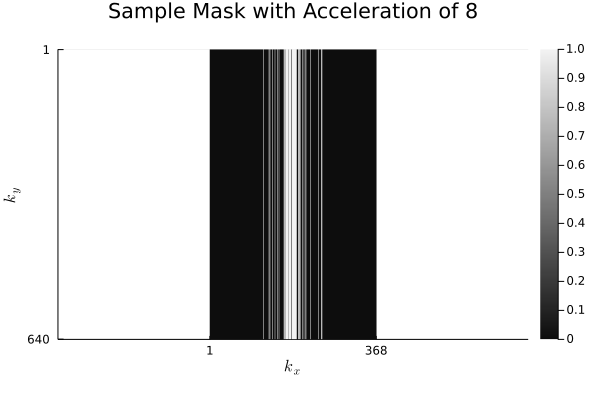

In [118]:
# Specify acceleration factor for sampling mask
R = 8
if R == 1
    sampleMask = ones(Bool, M, N)
    M_us = M
else
    M_us = Int(round(M/R)) # Undersampled number of points
    # Create a 1D random undersampling mask
    sampleMask = create_sampling_mask(M, N, R, seed=0)
end
using LaTeXStrings
jim(sampleMask, title="Sample Mask with Acceleration of " * string(R), xlabel=L"k_x", ylabel=L"k_y")

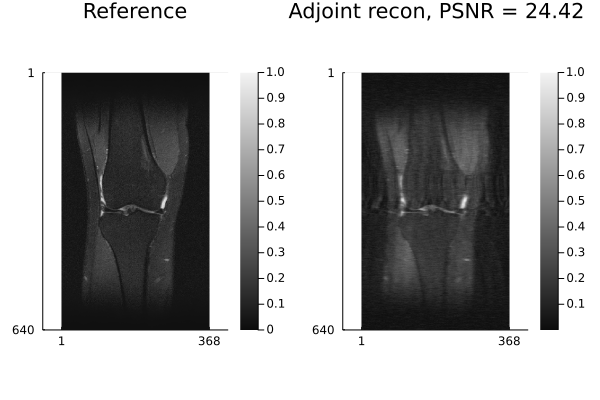

In [217]:
# Create linear map, A, that describes the MRI system model
A = LinearMapAA(x -> sys_forw(x, sampleMask), x -> sys_adj(x,sampleMask), (M_us*N, M*N))
# Apply model to image -> generate an undersampled k-space
y = A*noisy_img[:]
# Applying adjoint model to k-space reconstructs the image (poorly)
x0 = abs.(reshape(A'*y,M,N)) |> (x) -> x/max(x...)
# Make some plots
psnrAdjoint = assess_psnr(x0, img) # PSNR
j1 = jim(abs.(rev(img)),title="Reference")
j2 = jim(rev(x0),title="Adjoint recon, PSNR = $(round(psnrAdjoint, digits = 2))")
plot(j1, j2)

## Plug and Play!

In [8]:
nIter = 10

10

### Using DNCNN

In [218]:
plug = (x)-> dncnn_denoise(float32.(abs.(x))) |> (x) -> x/max(x...)
x̂DNCNN = @suppress admm((z,η,μ) -> primal(z,η,μ,A,sampleMask,y),
    plug,
    1,
    x0, 
    niter = nIter)
# Reshape and normalize
x̂DNCNN = reshape(abs.(x̂DNCNN),M,N) |> (x) -> x/max(x...);

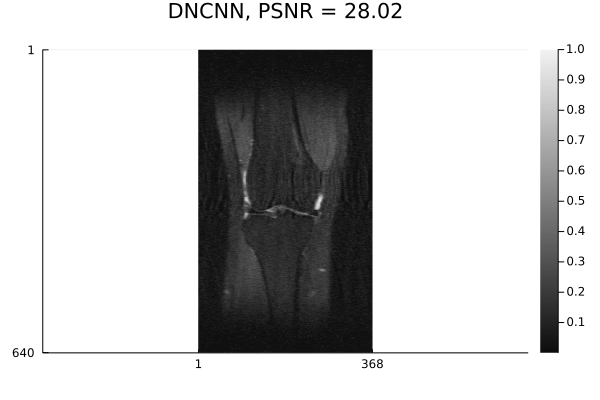

In [223]:
psnrDNCNN = assess_psnr(x̂DNCNN, img) # PSNR
pDNCNN = jim(abs.(rev(x̂DNCNN)), title="DNCNN, PSNR = $(round(psnrDNCNN, digits = 2))")

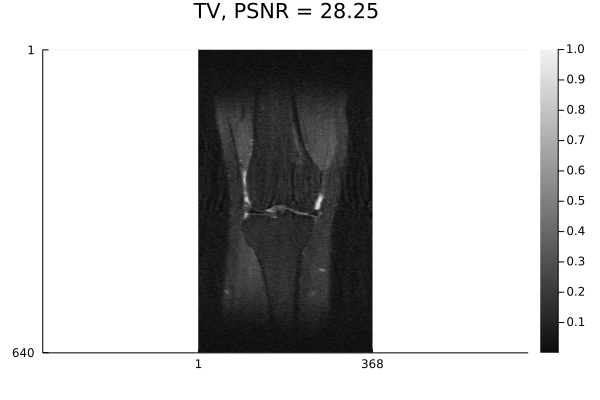

In [219]:
using Images: imROF
# plug = (x)-> imROF(abs.(x), 0.0005, 3) |> (x) -> x/max(x...) # for acceleration 4
plug = (x)-> imROF(abs.(x), 0.002, 4) |> (x) -> x/max(x...)
x̂Tv = @suppress admm((z,η,μ) -> primal(z,η,μ,A,sampleMask,y),
    plug,
    1,
    x0, 
    niter = nIter)
# Reshape and normalize
x̂Tv = reshape(abs.(x̂Tv),M,N) |> (x) -> x/max(x...);
psnrTv = assess_psnr(x̂Tv, img) # PSNR
pTv = jim(abs.(rev(x̂Tv)), title="TV, PSNR = $(round(psnrTv, digits = 2))")

### Using NLMeans

In [220]:
h = 3.0
plug = (x) -> nlMeans(abs.(x), h)
x̂NLMeans = @suppress admm((z,η,μ) -> primal(z,η,μ,A,sampleMask,y),
    plug,
    1,
    x0, 
    niter = nIter)
# Reshape and normalize
x̂NLMeans = reshape(abs.(x̂NLMeans),M,N) |> (x) -> x/max(x...);

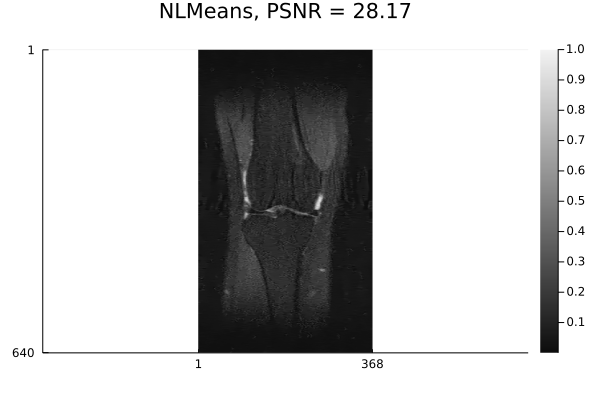

In [224]:
psnrNLMeans = assess_psnr(x̂NLMeans, img) # PSNR
pNLMeans = jim(abs.(rev(x̂NLMeans)), title="NLMeans, PSNR = $(round(psnrNLMeans, digits = 2))")

### Using BM3D

In [221]:
h    = 0.08
plug = (x) -> @suppress bm3d(abs.(x), h) |> (x) -> x/max(x...)
x̂BM3D = @suppress admm((z,η,μ) -> primal(z,η,μ,A,sampleMask,y),
    plug,
    1,
    x0, 
    niter = 10)
x̂BM3D = reshape(abs.(x̂BM3D),M,N) |> (x) -> x/max(x...);

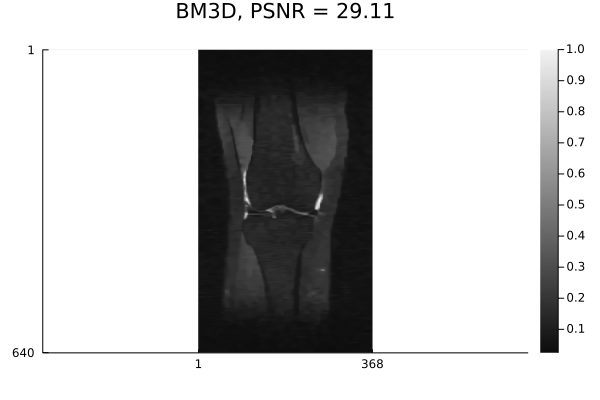

In [208]:
psnrBM3D = assess_psnr(x̂BM3D, img) # PSNR
pBM3D = jim(abs.(rev(x̂BM3D)), title="BM3D, PSNR = $(round(psnrBM3D, digits = 2))")

In [15]:
@show psnrNLMeans
@show psnrDNCNN # PSNR
@show psnrBM3D

psnrNLMeans = 31.209470359487007
psnrDNCNN = 31.513454521950976
psnrBM3D = 29.81751653400709


29.81751653400709

### Using normalization

In [222]:
plug = (x) -> abs.(x) |> (x) -> x/max(x...)
x̂ = @suppress admm((z,η,μ) -> primal(z,η,μ,A,sampleMask,y),
    plug,
    1,
    x0, 
    niter = nIter)
x̂ = reshape(abs.(x̂),M,N) |> (x) -> x/max(x...);

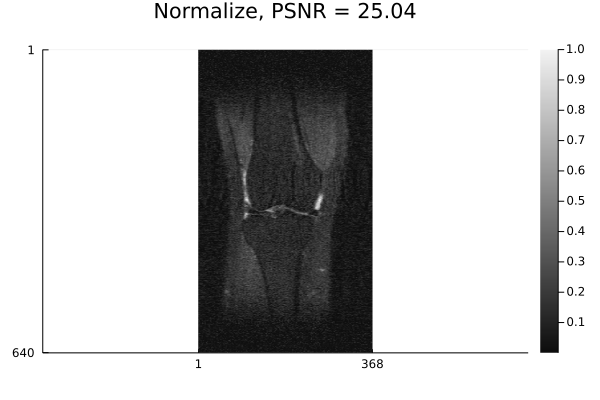

In [205]:
psnr = assess_psnr(x̂, img) # PSNR
p = jim(abs.(rev(x̂)), title="Normalize, PSNR = $(round(psnr, digits = 2))")

In [227]:
psnrNoisey = assess_psnr(noisy_img, img) # PSNR
pNoisey = jim(abs.(rev(noisy_img)),title="Noisy input, PSNR = $(round(psnrNoisey, digits = 2))");
# blank1 = plot([], axis=([], false), legend=false);
# blank2 = plot([], axis=([], false), legend=false);
plot(j1, pNoisey, j2, pDNCNN, pNLMeans, pBM3D, pTv, p, layout = (2,4), colorbar = false, size = (900,700), titlefontsize = 10)

In [180]:
# plot(p)

In [20]:
savefig("admm_knee_R4_norm.pdf")

LoadError: UndefVarError: savefig not defined